This is part 1 of a tutorial on how to evaluate streak camera data using python. There's actually a part 0 which is the README. At this point you've most likely completed all installation steps but the end of the README also explains some basic concepts about working with JupyterLab so make sure to read that first.  
This part of the tutorial deals with the import and correction process.

## Import necessary python modules

In [1]:
from copy import deepcopy as dc

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from streakimage import StreakImage

## Import Data

### Load background

In [2]:
path_to_bg = "files/example_bg ST4 g20 20x556ms.img"
bg = StreakImage(path_to_bg)

### Load image

In [3]:
path_to_img = "files/example_streak-image ST4 g20 20x556ms.img"
image = StreakImage(path_to_img, bg=bg)

Normally we would just execute the corrections one after the other without preserving the intermediate states of the image. Since this notebook is a place for experimenting we create [deepcopies](https://docs.python.org/2/library/copy.html) of our image before every correction.  

In [4]:
image_raw = dc(image)

### Plot raw data

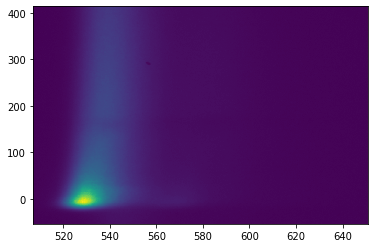

In [5]:
plt.pcolormesh(image.data.columns, image.data.index, image.data, shading="nearest")

Matplotlib supports a wide variety of [colormaps](https://matplotlib.org/api/pyplot_summary.html?highlight=colormaps#matplotlib.pyplot.colormaps). They can be explicitly set with the *cmap* argument. The colormap *jet* together with a logarithmic normalization of the colormap (*norm=mpl.colors.LogNorm()*) greatly enhances the visibility of small features.

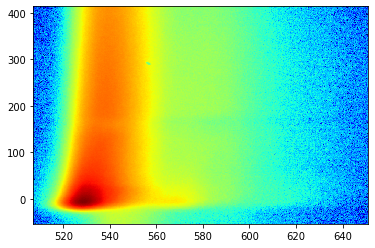

In [6]:
plt.pcolormesh(
    image.data.columns,
    image.data.index,
    image.data,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm(),
)

A colorbar can be added as shown below.

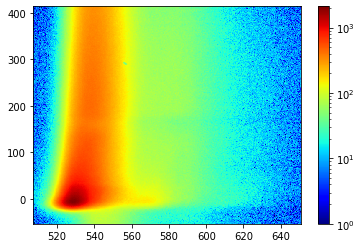

In [7]:
fig = plt.pcolormesh(
    image.data.columns,
    image.data.index,
    image.data,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(fig)

## Correct image stepwise

The image data is stored in a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Subsets of the data frame can be selected with the [loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) and [iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) functions.
While loc takes labels as indices as arguments, iloc takes absolut column position. The linked documentations list the different types of posslible arguments.
The syntax is loc\[time_from : time_to, wavelength_from : wavelength_to\] or iloc\[line_from : line_to, column_from : column_to\] 
respectively.
loc and iloc can be combined by chaning (see below). For more information refer to the linked documentations.

### Offset correction

The manual offset is calculated from 'dark' area in the image.
This area has to be identified first. In the ST4 example the lower right corner (wl=620nm+,t<0) seems to be a good spot.
In most cases it's better to refer to lines than to time for the vertical dimension of this area. This is due to the fact that the time axis is shifted (to position the origin at the maximum of the pl) during import. Using time to define the offset area would lead to different sizes of that area.

The area can be adjusted until there is no significant variation of the intensity (besides the inevitable noise) that could result from an actual signal.

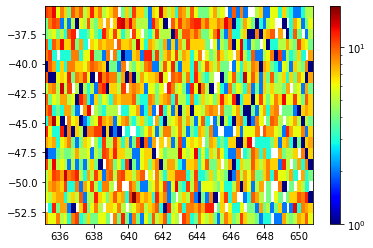

In [8]:
# definig variables vor better readability
wl_from = 635
wl_to = None

time_from = None
time_to = None
line_from = None
line_to = 20


data_subset = image.data.loc[time_from:time_to, wl_from:wl_to].iloc[
    line_from:line_to
]  # note that most of these variables are just None an thus ignored
fig = plt.pcolormesh(
    data_subset.columns,
    data_subset.index,
    data_subset,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(fig)

When the offset are is selected the offset can be calculated and subtractet from the image.

In [9]:
offset = data_subset.mean().mean()
offset

5.546428571428572

In [10]:
image_offset_cor = dc(image_raw)
image_offset_cor.data -= offset

Recalculating and plotting the data_subset clearly shows the impact of the offset subtraction 

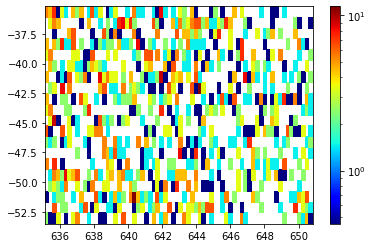

In [11]:
data_subset = image_offset_cor.data.loc[time_from:time_to, wl_from:wl_to].iloc[
    line_from:line_to
]
fig = plt.pcolormesh(
    data_subset.columns,
    data_subset.index,
    data_subset,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(fig)

Looking at the image as a whole the impact is much more subtle.

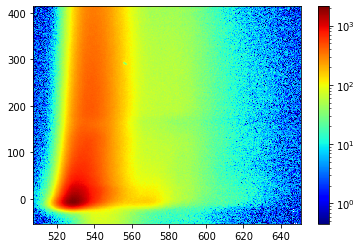

In [12]:
fig = plt.pcolormesh(
    image_offset_cor.data.columns,
    image_offset_cor.data.index,
    image_offset_cor.data,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm(),
)
plt.colorbar(fig)

To highlight the effect one can set an upper limit for the color scale (vmax) and compare the corrected image to the uncorrected one.

The same call will be made multiple times. Therefore we define a function that will save us a lot of code in the following cells.

In [13]:
def plot_heatmap(
    df: pd.DataFrame,
    fig: mpl.figure.Figure,
    ax,
    shading="nearest",
    cmap="jet",
    norm=mpl.colors.LogNorm,
    vmin=None,
    vmax=None,
    title: str = None,
):
    hm = ax.pcolormesh(
        df.columns,
        df.index,
        df,
        shading=shading,
        cmap=cmap,
        norm=norm(vmin=vmin, vmax=vmax),
    )
    fig.colorbar(hm, ax=ax)
    if title:
        ax.set_title(title)

The paragraph [Parts of a Figure](https://matplotlib.org/tutorials/introductory/usage.html#parts-of-a-figure) in the [Matplotlib Usage Guide](https://matplotlib.org/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py) gives an overview on how Matplotlib names the components of a figure.

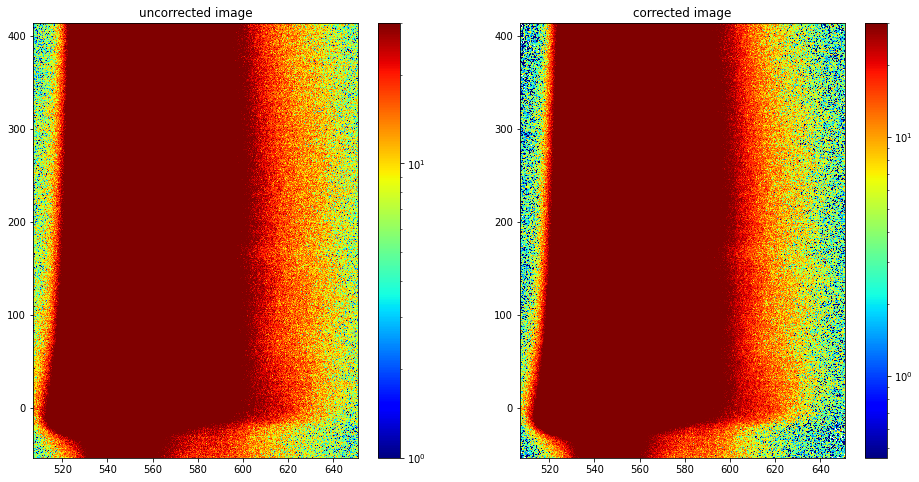

In [14]:
# Create a figure with two axes
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# upper limit for the color map
vmax = 30

# Plot the raw and the offset corrected image each to its own axes
plot_heatmap(
    df=image_raw.data, fig=fig, ax=axes[0], title="uncorrected image", vmax=vmax
)
plot_heatmap(
    df=image_offset_cor.data, fig=fig, ax=axes[1], title="corrected image", vmax=vmax
)

The other corrections do not need user input. A before and after image is shown for each correction to illustrate their impact on the image.

### Gain and Exposure Correction

The impact of the gain is corrected by dividing the data by a certain coefficient:

| Gain | Coefficient |  
|------|-------------|  
| 0    | 1           |  
| 10   | 4.9         |  
| 20   | 20.5        |  
| 30   | 70          |  
| 40   | 205         |  
| 50   | 507         |  
| 60   | 994         |  

Exposure time and accumulated measurements are corrected by dividing the data by the product of exposure time and the number of accumulations.
Since both corrections are similar and only reflected on the scale of the colorbar we look at them at once. 

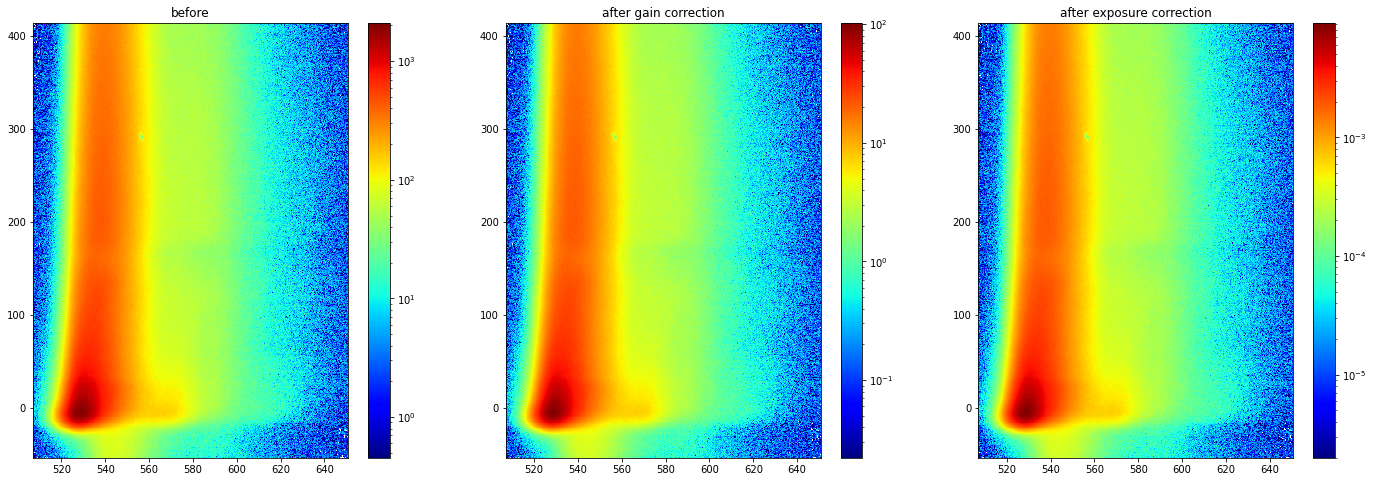

In [15]:
image_gain_cor = dc(image_offset_cor)
image_gain_cor.apply_gain_correction()
image_exp_cor = dc(image_gain_cor)
image_exp_cor.apply_exp_correction()

fig_gc, axes_gc = plt.subplots(1, 3, figsize=(24, 8))

plot_heatmap(df=image_offset_cor.data, fig=fig_gc, ax=axes_gc[0], title="before")
plot_heatmap(
    df=image_gain_cor.data, fig=fig_gc, ax=axes_gc[1], title="after gain correction"
)
plot_heatmap(
    df=image_exp_cor.data, fig=fig_gc, ax=axes_gc[2], title="after exposure correction"
)

### Camera Correction

The camera correction is the most important correction. It divides the data by reference data thus correcting for sensor sensitivity. As the camera sensor ages, updated correction data is needed. The way to do this is documented in the [streakimage](https://github.com/nicohofdtz/streakimage) project.

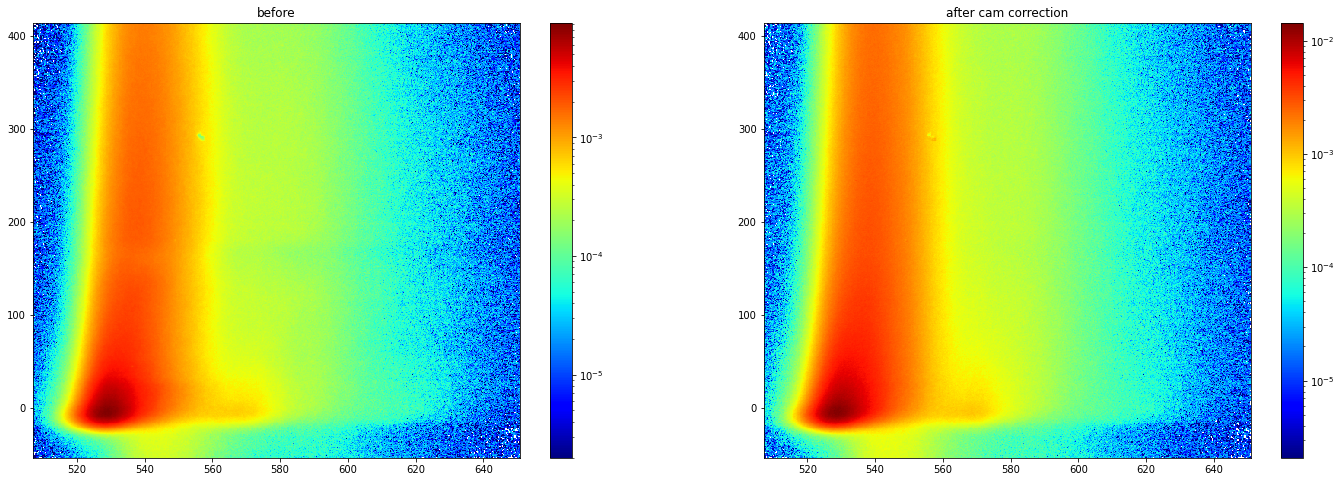

In [16]:
image_cam_cor = dc(image_exp_cor)
image_cam_cor.apply_camera_correction()

fig_cc, axes_cc = plt.subplots(1, 2, figsize=(24, 8))

plot_heatmap(df=image_exp_cor.data, fig=fig_cc, ax=axes_cc[0], title="before")
plot_heatmap(
    df=image_cam_cor.data, fig=fig_cc, ax=axes_cc[1], title="after cam correction"
)

### Mono Correction

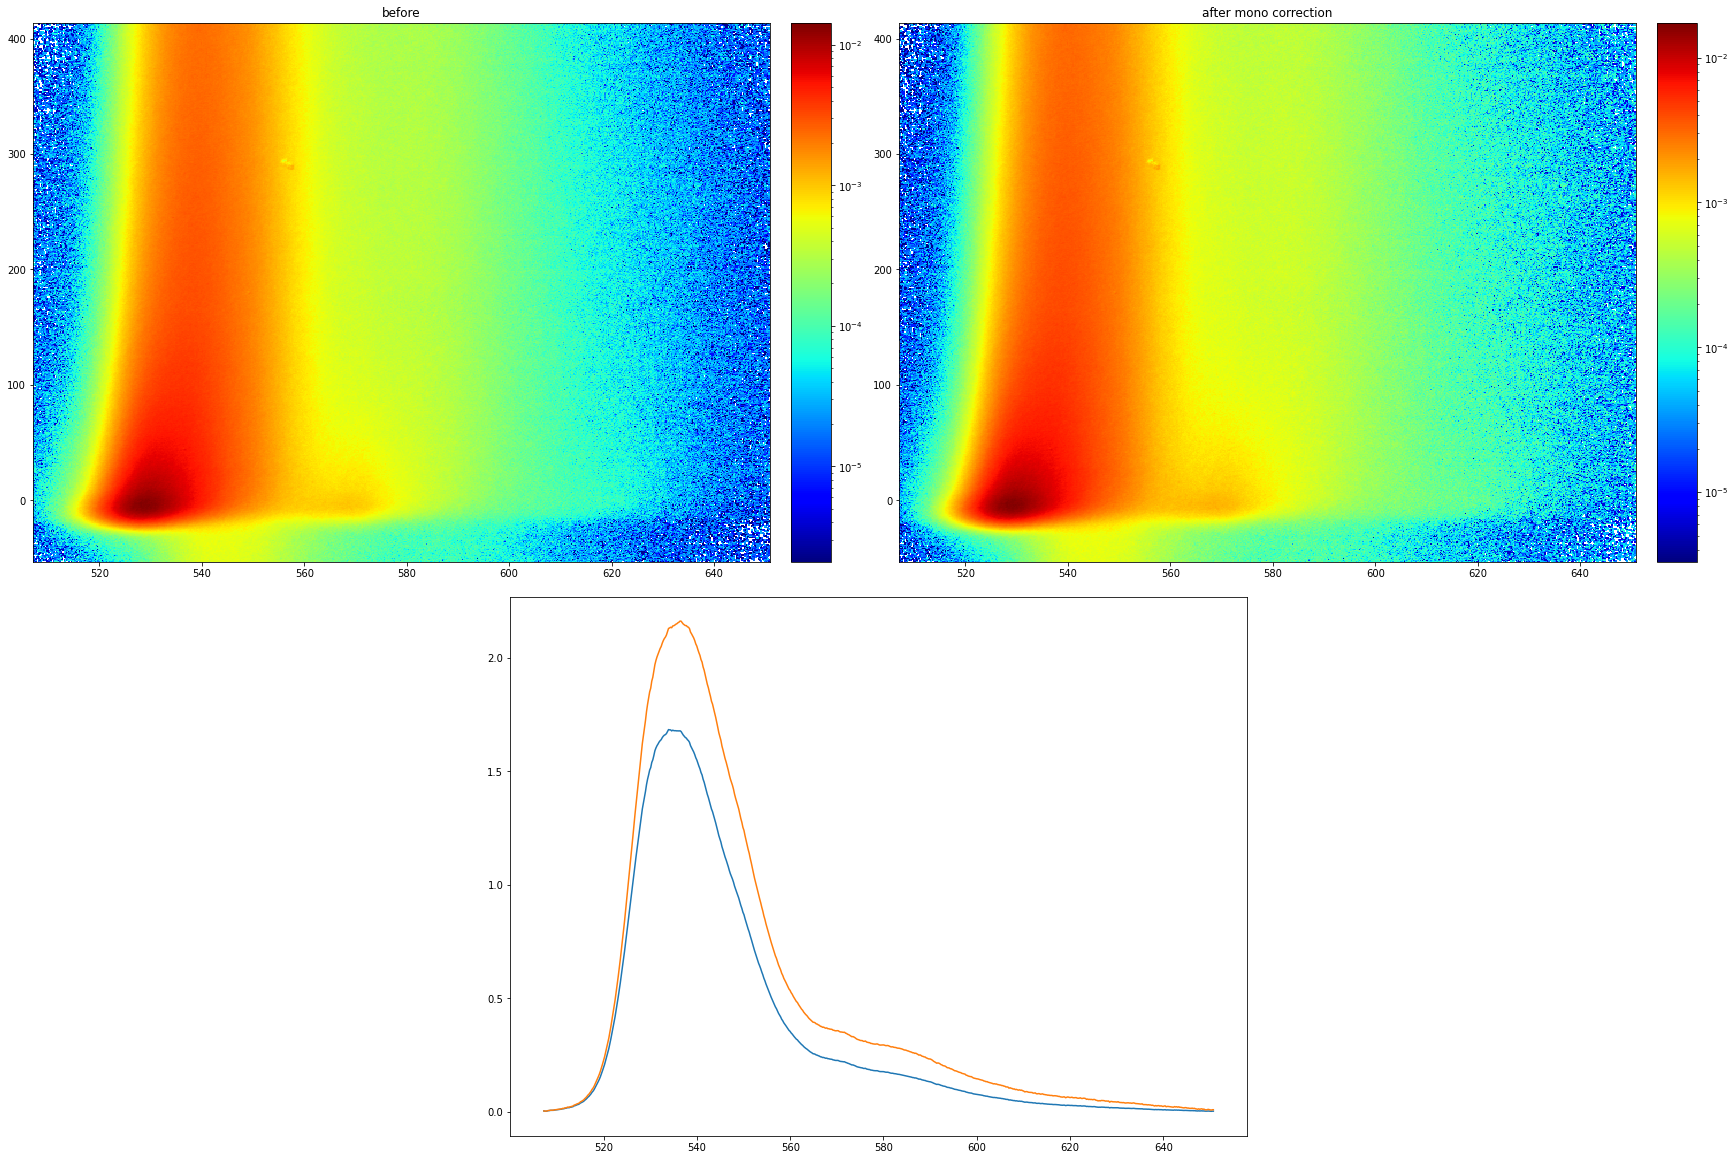

In [18]:
image_mono_cor = dc(image_cam_cor)
# image_mono_cor.data.columns -= 300
image_mono_cor.apply_mono_correction()

fig_mc =plt.figure(constrained_layout=True, figsize=(24,16))
gs = fig_mc.add_gridspec(2,8)
fig_mc_ax1=fig_mc.add_subplot(gs[0,:4])
fig_mc_ax2=fig_mc.add_subplot(gs[0,4:])
fig_mc_ax3=fig_mc.add_subplot(gs[1,2:6])

plot_heatmap(df=image_cam_cor.data, fig=fig_mc, ax=fig_mc_ax1, title='before')
plot_heatmap(df=image_mono_cor.data, fig=fig_mc, ax=fig_mc_ax2, title='after mono correction')

fig_mc_ax3.plot(np.sum(image_cam_cor.data))
fig_mc_ax3.plot(np.sum(image_mono_cor.data))

Now, that we know how to load and correct our data we can move on to processing this data.